In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

d:\python\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
data = pd.read_csv("../data/loan_data_2007_2014.csv", index_col=0)
df = data.copy()
df.head()

C:\Users\Jayy\AppData\Local\Temp\ipykernel_20464\454855539.py:1: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../data/loan_data_2007_2014.csv", index_col=0)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

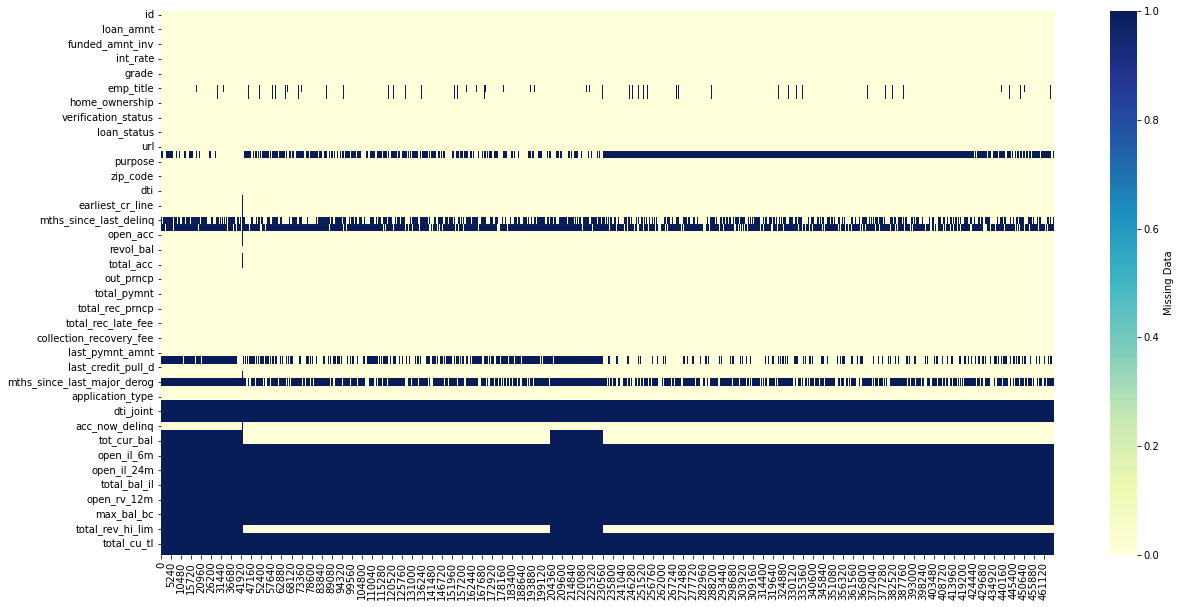

In [3]:
plt.figure(figsize=(20,10))
sns.heatmap(df.isna().T,
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})


In [4]:
df.isna().sum().unique()

array([     0,  27588,  21008,      4, 340302,     20,     29, 250351,
       403647,    340,    376, 227214,     42,    145, 367311, 466285,
        70276], dtype=int64)

In [5]:
df.isna().sum()

id                       0
member_id                0
loan_amnt                0
funded_amnt              0
funded_amnt_inv          0
                     ...  
all_util            466285
total_rev_hi_lim     70276
inq_fi              466285
total_cu_tl         466285
inq_last_12m        466285
Length: 74, dtype: int64

In [6]:
df.shape

(466285, 74)

In [7]:
df = df[df.columns[(df.isna().sum() <= 200000)]]
df.shape, df.isna().sum().unique()

((466285, 52),
 array([    0, 27588, 21008,     4,    20,    29,   340,   376,    42,
          145, 70276], dtype=int64))

## mengatasi missing value intuk kolom emp title

saya akan untuk meng impute kolom tersebut dengan nilai emp title yang lain dengan rata2 loan amt yang mirip dengan rata2 loan amt pada kolom yang terdapat missing value

In [8]:
df.columns[(df.isna().sum() == 27588)]

Index(['emp_title'], dtype='object')

In [9]:
# mencari rata2 dan maksimum dari kolom emp_title yang memiliki missing value
df[df['emp_title'].isna()].describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
count,2.758800e+04,2.758800e+04,27588.000000,27588.000000,27588.000000,27588.000000,27588.000000,2.758400e+04,27588.000000,27576.000000,...,27588.000000,27588.000000,27588.000000,27588.000000,27564.000000,27588.0,27576.000000,23250.000000,2.325000e+04,2.325000e+04
mean,1.226417e+07,1.374623e+07,12450.038966,12423.555531,12370.576206,13.882511,389.109667,5.993913e+04,17.355970,0.244996,...,0.686942,84.508664,8.952722,2167.769587,0.009287,1.0,0.003626,234.189978,1.052996e+05,2.873323e+04
std,1.054599e+07,1.130764e+07,8149.973629,8125.978976,8133.407097,4.337363,248.782936,4.950587e+04,8.391918,0.731293,...,5.546348,525.725315,95.506122,4467.842366,0.107009,0.0,0.063628,2027.407953,1.382322e+05,3.371894e+04
min,5.473400e+04,7.047300e+04,500.000000,500.000000,0.000000,5.420000,15.690000,2.000000e+03,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,3.630122e+06,4.319177e+06,6000.000000,6000.000000,6000.000000,10.990000,202.977500,3.200000e+04,10.910000,0.000000,...,0.000000,0.000000,0.000000,245.267500,0.000000,1.0,0.000000,0.000000,1.577825e+04,1.190000e+04
50%,9.270024e+06,1.102986e+07,10000.000000,10000.000000,10000.000000,13.670000,330.700000,4.945150e+04,17.020000,0.000000,...,0.000000,0.000000,0.000000,431.260000,0.000000,1.0,0.000000,0.000000,4.259400e+04,2.020000e+04
75%,1.855476e+07,2.064871e+07,17000.000000,17000.000000,17000.000000,16.692500,513.330000,7.152000e+04,23.460000,0.000000,...,0.000000,0.000000,0.000000,1059.977500,0.000000,1.0,0.000000,0.000000,1.580712e+05,3.470000e+04
max,3.784184e+07,4.060491e+07,35000.000000,35000.000000,35000.000000,26.060000,1409.990000,1.440000e+06,39.990000,13.000000,...,189.180000,23035.920000,6972.590000,35680.840000,6.000000,1.0,2.000000,126297.000000,3.437283e+06,1.998700e+06


In [10]:
# saya menemukan bahwa nilai rata2 loat_amnt dari kolom yang memiliki missing value ada diangka 12450.038966 maka dari itu saya mencoba mencari pekerjaan lain yang memiliki nilai rata2 loan_amnt yang lebih besar dari 12000 dan lebih kecil dari 13000

lower_bound = 12000
upper_bound = 13000

job = df.groupby('emp_title').filter(lambda x: ((x.loan_amnt >= lower_bound) & (x.loan_amnt <= upper_bound)).all())

berikut adalah list pekerjaan lain yang memiliki rata2 loan_amnt lebih besar dari 12000 dan lebih kecil dari 13000

In [11]:
job['emp_title'].value_counts()

Cleary Gottlieb                          3
Departmental Technician                  3
Waffle House                             3
DRVER                                    2
derrick man                              2
                                        ..
FAA/Ontario Air Traffic Control Tower    1
T White Trkg inc.                        1
industrial threaded products             1
Holsum Bakery of Tolleson, LLC           1
Director of High Performance             1
Name: emp_title, Length: 14057, dtype: int64

karena hasil tersebut tidak menunjukkan adanya data yang berkumpul, maka dari itu saya memutuskan untuk meng impute kolom tersebut dengan Unknown

In [12]:
df['emp_title'].fillna('Other', inplace=True)

In [13]:
df.isna().sum()

id                                0
member_id                         0
loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
term                              0
int_rate                          0
installment                       0
grade                             0
sub_grade                         0
emp_title                         0
emp_length                    21008
home_ownership                    0
annual_inc                        4
verification_status               0
issue_d                           0
loan_status                       0
pymnt_plan                        0
url                               0
purpose                           0
title                            20
zip_code                          0
addr_state                        0
dti                               0
delinq_2yrs                      29
earliest_cr_line                 29
inq_last_6mths                   29
open_acc                    

## mengatasi missing value intuk kolom emp title

sama seperti sebelumnya, saya berniat untuk mengimpute nilai yang kosong dengan nilai lain yang memiliki rata amt amount yang mirip

In [14]:
#menihat bagaimana persebaran data pada kolom ini
df.emp_length.value_counts()

10+ years    150049
2 years       41373
3 years       36596
< 1 year      36265
5 years       30774
1 year        29622
4 years       28023
7 years       26180
6 years       26112
8 years       22395
9 years       17888
Name: emp_length, dtype: int64

In [15]:
#mencari rata2 amt amount dari kolom yang memiliki missing value
df[df['emp_length'].isna()].describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
count,2.100800e+04,2.100800e+04,21008.000000,21008.000000,21008.000000,21008.000000,21008.000000,21008.000000,21008.000000,21008.000000,...,21008.000000,21008.000000,21008.000000,21008.000000,21008.000000,21008.0,21008.000000,18947.000000,1.894700e+04,18947.000000
mean,1.453701e+07,1.621312e+07,11542.995526,11533.108816,11520.005556,13.966062,359.853819,49428.978403,18.451529,0.245621,...,0.483539,64.982890,7.405490,1981.774990,0.010901,1.0,0.003713,249.546577,9.261982e+04,26804.934079
std,1.090263e+07,1.161648e+07,7506.910922,7497.977584,7491.605228,4.295129,223.879042,30929.049883,8.348041,0.741836,...,4.430532,452.302013,69.043543,4137.360676,0.117191,0.0,0.064617,2038.887405,1.154398e+05,26749.654219
min,4.415470e+05,4.988400e+05,1000.000000,1000.000000,400.000000,5.420000,23.010000,3000.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000e+00,0.000000
25%,5.790457e+06,7.190107e+06,6000.000000,6000.000000,5950.000000,10.990000,194.662500,30000.000000,12.170000,0.000000,...,0.000000,0.000000,0.000000,231.400000,0.000000,1.0,0.000000,0.000000,1.423350e+04,11500.000000
50%,1.172809e+07,1.367827e+07,10000.000000,10000.000000,10000.000000,13.980000,315.265000,44500.000000,18.310000,0.000000,...,0.000000,0.000000,0.000000,388.060000,0.000000,1.0,0.000000,0.000000,3.796700e+04,19200.000000
75%,2.280513e+07,2.497789e+07,15075.000000,15000.000000,15000.000000,16.780000,477.115000,61503.250000,24.600000,0.000000,...,0.000000,0.000000,0.000000,881.225000,0.000000,1.0,0.000000,0.000000,1.420410e+05,32900.000000
max,3.784184e+07,4.060491e+07,35000.000000,35000.000000,35000.000000,26.060000,1368.750000,900000.000000,39.990000,13.000000,...,184.600000,23035.920000,4146.465600,35680.840000,6.000000,1.0,2.000000,126297.000000,1.500259e+06,649300.000000


In [16]:
# membuat lower bound dan upper bound untuk kolom emp_length
lower_bound = 11500
upper_bound = 11600


# melakukan filtering data berdasarkan lower bound dan upper bound
length = df.groupby('emp_title').filter(lambda x: ((x.loan_amnt.mean() >= lower_bound) & (x.loan_amnt.mean() <= upper_bound)).all())

In [17]:
# mendapatkan hasil bahwa berdasarkan hasil filtering sebelumnya didapat bahwa adanya data yang berkumpul yaitu ada di 10=years sehingga saya akan mengimpute 10=years ke kolom emp_length

length.emp_length.value_counts()

10+ years    745
2 years      258
< 1 year     232
5 years      207
3 years      196
4 years      182
6 years      177
1 year       168
7 years      151
8 years      133
9 years      112
Name: emp_length, dtype: int64

In [18]:
# mengimpute data ke kolom emp_length

df['emp_length'].fillna('10+ years', inplace=True)

In [19]:
# mengecek apakah ada data yang memiliki missing value

df.isna().sum()

id                                0
member_id                         0
loan_amnt                         0
funded_amnt                       0
funded_amnt_inv                   0
term                              0
int_rate                          0
installment                       0
grade                             0
sub_grade                         0
emp_title                         0
emp_length                        0
home_ownership                    0
annual_inc                        4
verification_status               0
issue_d                           0
loan_status                       0
pymnt_plan                        0
url                               0
purpose                           0
title                            20
zip_code                          0
addr_state                        0
dti                               0
delinq_2yrs                      29
earliest_cr_line                 29
inq_last_6mths                   29
open_acc                    

## mengatasi missing value pada kolom tot_coll_amt, tot_cur_bal, dan total_rev_hi_lim

saya berniat untuk mengimpute kolomg tersebut dengan nilai data2 dari setiap kolom

In [20]:
# mencari rata2 dari setiap kolom

df['tot_coll_amt'].describe(), df['tot_cur_bal'].describe(), df['total_rev_hi_lim'].describe()

(count    3.960090e+05
 mean     1.919135e+02
 std      1.463021e+04
 min      0.000000e+00
 25%      0.000000e+00
 50%      0.000000e+00
 75%      0.000000e+00
 max      9.152545e+06
 Name: tot_coll_amt, dtype: float64,
 count    3.960090e+05
 mean     1.388017e+05
 std      1.521147e+05
 min      0.000000e+00
 25%      2.861800e+04
 50%      8.153900e+04
 75%      2.089530e+05
 max      8.000078e+06
 Name: tot_cur_bal, dtype: float64,
 count    3.960090e+05
 mean     3.037909e+04
 std      3.724713e+04
 min      0.000000e+00
 25%      1.350000e+04
 50%      2.280000e+04
 75%      3.790000e+04
 max      9.999999e+06
 Name: total_rev_hi_lim, dtype: float64)

In [21]:
# mengimpute kolom tersebut dengan nilai rata2

df['tot_coll_amt'].fillna(df['tot_coll_amt'].mean(), inplace=True)
df['tot_cur_bal'].fillna(df['tot_cur_bal'].mean(), inplace=True)
df['total_rev_hi_lim'].fillna(df['total_rev_hi_lim'].mean(), inplace=True)

In [22]:
# melihat hasil impute apakah nilai rata2 dari setiap kolom berubah banyak atau tidak

df['tot_coll_amt'].describe(), df['tot_cur_bal'].describe(), df['total_rev_hi_lim'].describe()

(count    4.662850e+05
 mean     1.919135e+02
 std      1.348272e+04
 min      0.000000e+00
 25%      0.000000e+00
 50%      0.000000e+00
 75%      6.200000e+01
 max      9.152545e+06
 Name: tot_coll_amt, dtype: float64,
 count    4.662850e+05
 mean     1.388017e+05
 std      1.401838e+05
 min      0.000000e+00
 25%      3.361100e+04
 50%      1.271600e+05
 75%      1.849300e+05
 max      8.000078e+06
 Name: tot_cur_bal, dtype: float64,
 count    4.662850e+05
 mean     3.037909e+04
 std      3.432571e+04
 min      0.000000e+00
 25%      1.500000e+04
 50%      2.710000e+04
 75%      3.430000e+04
 max      9.999999e+06
 Name: total_rev_hi_lim, dtype: float64)

In [23]:
df.isna().sum()

id                              0
member_id                       0
loan_amnt                       0
funded_amnt                     0
funded_amnt_inv                 0
term                            0
int_rate                        0
installment                     0
grade                           0
sub_grade                       0
emp_title                       0
emp_length                      0
home_ownership                  0
annual_inc                      4
verification_status             0
issue_d                         0
loan_status                     0
pymnt_plan                      0
url                             0
purpose                         0
title                          20
zip_code                        0
addr_state                      0
dti                             0
delinq_2yrs                    29
earliest_cr_line               29
inq_last_6mths                 29
open_acc                       29
pub_rec                        29
revol_bal     

In [24]:
df.isna().sum().unique()

array([  0,   4,  20,  29, 340, 376,  42, 145], dtype=int64)

## sisa kolom yang memiliki missing value tidak akan saya impute melainkan akan saya drop

In [25]:
df.dropna(inplace=True)

In [26]:
df.isna().sum()

id                            0
member_id                     0
loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
grade                         0
sub_grade                     0
emp_title                     0
emp_length                    0
home_ownership                0
annual_inc                    0
verification_status           0
issue_d                       0
loan_status                   0
pymnt_plan                    0
url                           0
purpose                       0
title                         0
zip_code                      0
addr_state                    0
dti                           0
delinq_2yrs                   0
earliest_cr_line              0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    0
total_ac

<AxesSubplot:>

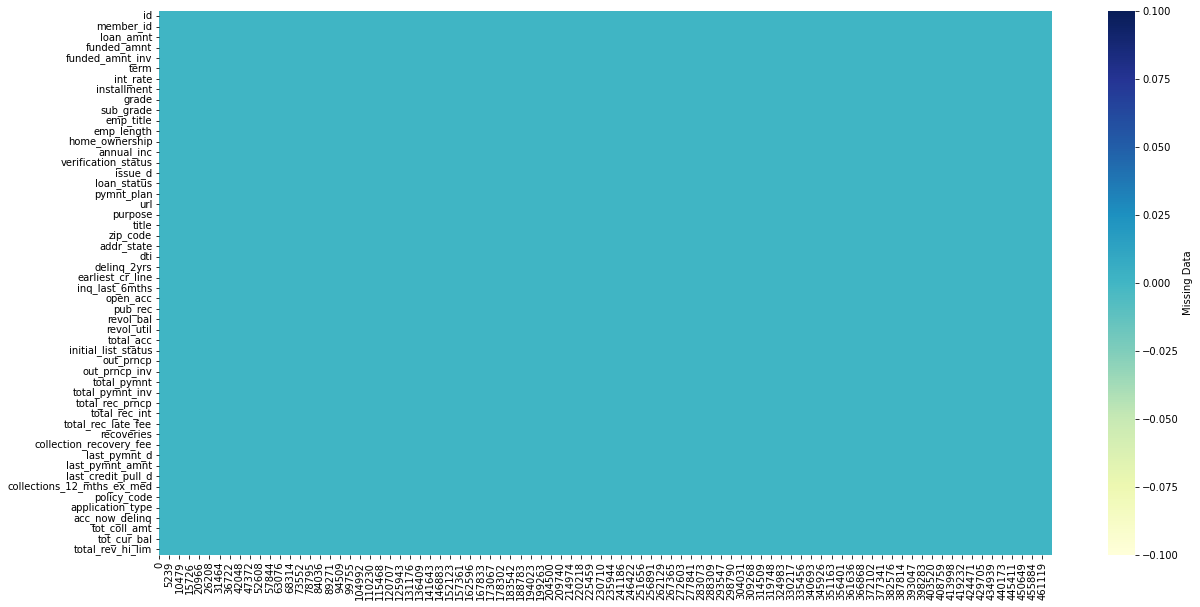

In [27]:
plt.figure(figsize=(20,10))
sns.heatmap(df.isna().T,
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})

In [28]:
df['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [29]:
df['loan_status'].value_counts()

Current                                                224096
Fully Paid                                             184524
Charged Off                                             42056
Late (31-120 days)                                       6895
In Grace Period                                          3144
Does not meet the credit policy. Status:Fully Paid       1913
Late (16-30 days)                                        1217
Default                                                   832
Does not meet the credit policy. Status:Charged Off       725
Name: loan_status, dtype: int64

In [30]:
mapping_loan_status = {
    'Current': 1,
    'Fully Paid': 1,
    'Charged Off': 0,
    'Late (31-120 days)': 0,
    'In Grace Period': 1,
    'Does not meet the credit policy. Status:Fully Paid': 1,
    'Late (16-30 days)': 0,
    'Default':1,
    'Does not meet the credit policy. Status:Charged Off':0
}

df['loan_status'] = df['loan_status'].map(mapping_loan_status)
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,Jan-15,171.62,Jan-16,0.0,1,INDIVIDUAL,0.0,191.913517,138801.713385,30379.087771
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,Apr-13,119.66,Sep-13,0.0,1,INDIVIDUAL,0.0,191.913517,138801.713385,30379.087771
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,Jun-14,649.91,Jan-16,0.0,1,INDIVIDUAL,0.0,191.913517,138801.713385,30379.087771
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,...,Jan-15,357.48,Jan-15,0.0,1,INDIVIDUAL,0.0,191.913517,138801.713385,30379.087771
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,...,Jan-16,67.79,Jan-16,0.0,1,INDIVIDUAL,0.0,191.913517,138801.713385,30379.087771


In [31]:
df['loan_status'].value_counts()

1    414509
0     50893
Name: loan_status, dtype: int64

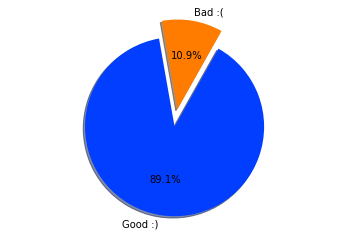

In [51]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = [ 'Good :)', 'Bad :(']
explode = (0, 0.2)  # only "explode" the 2nd slice (i.e. 'Hogs')

#define Seaborn color palette to use
colors = sns.color_palette('bright')[0:6]

fig1, ax1 = plt.subplots()
ax1.pie(df['loan_status'].value_counts(), explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=100, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

## menghapus kolom-kolom yang tidak digunakan

In [32]:
df.drop(columns=['id', 'member_id'], inplace=True)

In [54]:
df.drop(columns=['application_type'], inplace=True)

## sekarang data sudah bersih dari missing value

In [ ]:
cat = df[df.dtypes[df.dtypes == 'object'].index]
num = df[df.dtypes[df.dtypes != 'object'].index]

In [ ]:
cat.columns, num.columns

(Index(['term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
        'home_ownership', 'verification_status', 'issue_d', 'loan_status',
        'pymnt_plan', 'url', 'purpose', 'title', 'zip_code', 'addr_state',
        'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
        'last_credit_pull_d', 'application_type'],
       dtype='object'),
 Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
        'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
        'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
        'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
        'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
        'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
        'last_pymnt_amnt', 'collections_12_mths_ex_med', 'policy_code',
        'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim'],
       dtype='object'))